In [1]:
import sys
sys.path.insert(0, '../src')

from megs.model.mPCA import mPCA
from megs.data import image, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

# Load mm object from the file
filename = "morphmodel.pkl"
with open(filename, "rb") as file:
    mm = pickle.load(file)

In [158]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=5)  # The 'eps' parameter is the maximum distance between two samples for them to be considered as in the same cluster
dbscan.fit(mm.scores)

# The cluster assignments are stored in dbscan.labels_
print(dbscan.labels_)

# The number of clusters is stored in dbscan.labels_
print(len(set(dbscan.labels_)))

# plot some examples images from each cluster
#fig, ax = plt.subplots(1, 5, figsize=(15, 3))
#for i in range(5):
#    ax[i].imshow(mm.images[dbscan.labels_ == i][0], cmap='gray')
#    ax[i].axis('off')
#plt.show()




[-1 -1 -1 ... -1 -1 -1]
2


In [160]:
metalimg = datamatrix[:,0]

[0 0 0 ... 4 4 2]


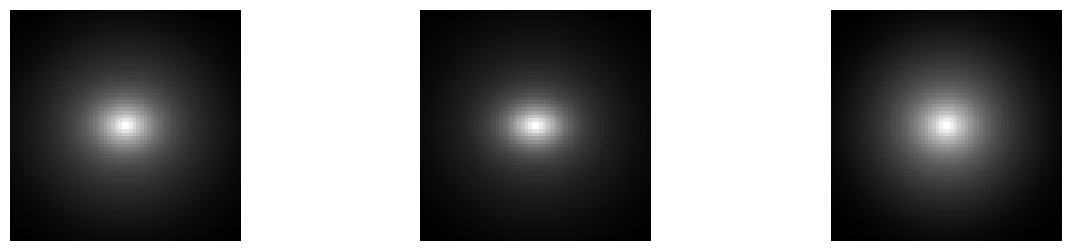

In [163]:
from sklearn.cluster import AgglomerativeClustering

agglomerative = AgglomerativeClustering(n_clusters=6)
agglomerative.fit(mm.scores)

# The cluster assignments are stored in agglomerative.labels_
print(agglomerative.labels_)



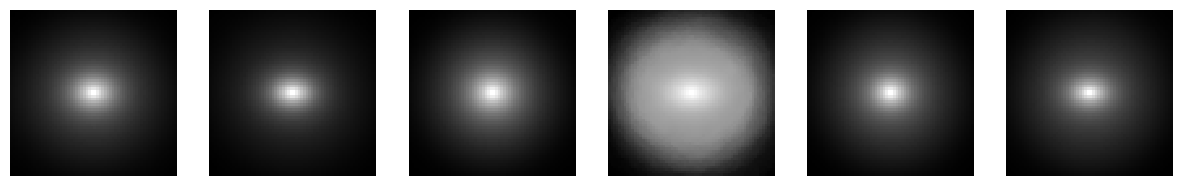

In [165]:
#print mean images for each cluster
fig, ax = plt.subplots(1, 6, figsize=(15, 3))
for i in range(6):
    ax[i].imshow(metalimg[agglomerative.labels_ == i].mean(axis=0), cmap='gray')
    ax[i].axis('off')

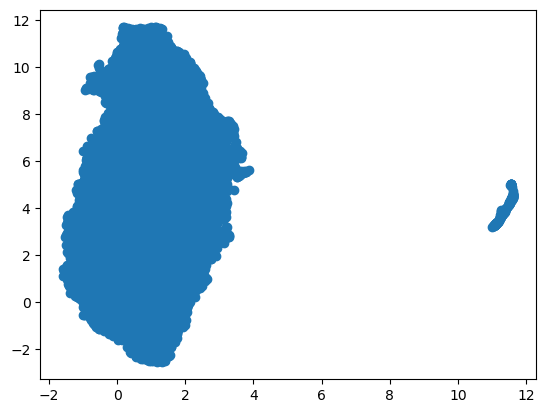

In [208]:
import umap
from mpl_toolkits.mplot3d import Axes3D

reducer = umap.UMAP(n_components=2, random_state=42, metric='euclidean', n_neighbors=10, min_dist=0.1)
embedding = reducer.fit_transform(mm.scores)  

plt.scatter(embedding[:, 0], embedding[:, 1])
plt.show()

 


In [196]:
indx = np.where(embedding[:, 0] > 10)[0]

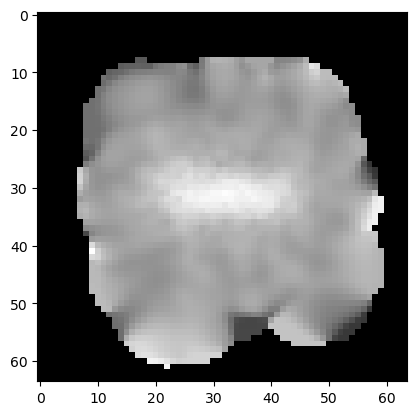

In [207]:
plt.imshow(metalimg[indx[9]], cmap='gray')

[[  617  2623     1  5866  4045]
 [ 5635   617  1808     0  3681]
 [ 8499 10730 10313  3405  8173]
 ...
 [12471 12337  4316 11320  2573]
 [ 2172  9826 11925  1041 12007]
 [  193  8735  7437   738  4446]]


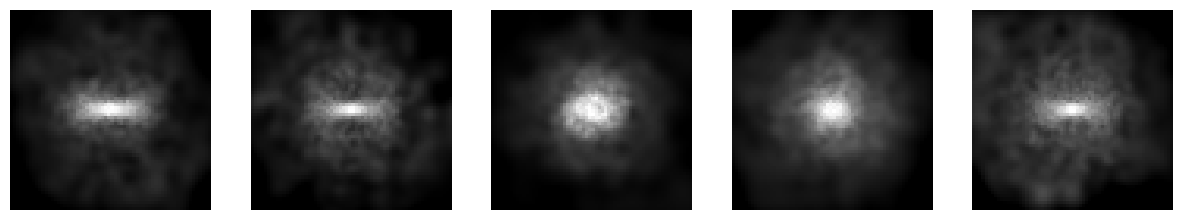

In [194]:

# show images that are close to each other in the embedding space
from sklearn.neighbors import NearestNeighbors


n = 5

galind= 22

neigh = NearestNeighbors(n_neighbors=n)
neigh.fit(embedding)



# The indices of the nearest neighbors are stored in neigh.kneighbors()[1]
print(neigh.kneighbors()[1])

# plot some examples images from each cluster
fig, ax = plt.subplots(1,n, figsize=(15, 3))
for i in range(n):
    ax[i].imshow(metalimg[neigh.kneighbors()[1][galind][i]], cmap='gray')
    ax[i].axis('off')
    
plt.show()


In [176]:
neigh.kneighbors()[1].shape

(12484, 10)

/export/home/ucakir/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/export/home/ucakir/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


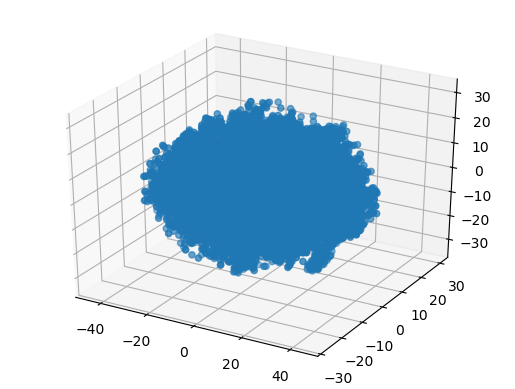

In [154]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

tsne = TSNE(n_components=3, random_state=42)
embedding = tsne.fit_transform(mm.scores)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2])
plt.show()


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import trange

In [3]:
datamatrix = mm.datamatrix.reshape(mm.datamatrix.shape[0], 3, 64, 64)

In [60]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = mm.datamatrix.reshape(12484, 3, 64, 64)
data = data[:, 0, :]  # Use only the first map to learn the model


targets = mm.scores
# targets = datamatrix




# Split the data into train and test sets
train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.2, random_state=42)

# Assuming you have your training data and targets as tensors
train_data = torch.Tensor(train_data).to(device)
train_targets = torch.Tensor(train_targets).to(device)

test_data = torch.Tensor(test_data).to(device)
test_targets = torch.Tensor(test_targets).to(device)

# Convert test data and targets into a TensorDataset

# Convert training data and targets into a TensorDataset
train_dataset = TensorDataset(train_data, train_targets)
test_dataset = TensorDataset(test_data, test_targets)


# Define the batch size for training
batch_size = 128



# Create the train_loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [61]:
def get_dataindex(img):
    index  = np.where(np.all(data == img, axis=1))[0][0]
    return index
def plot_results(index,scores_true, scores_pred,save_name = None, return_scores = False, show = True):
    
    
    fig, ax = plt.subplots(3, 3, figsize=(15, 15))
    groundtruth = mm.reconstruct(scores_true[index])
    pred = mm.reconstruct(scores_pred[index])
    
   # datindx = get_dataindex(groundtruth.numpy())
    metal_truth = groundtruth[0]
    age_truth = groundtruth[1]
    mass_truth = groundtruth[2]


    metal_rec = pred[0]
    age_rec = pred[1]
    mass_rec = pred[2]

    res_metal = np.abs(metal_truth - metal_rec)#/ np.abs(groundtruth) *100
    res_age = np.abs(age_truth - age_rec)#/ np.abs(age_truth) *100
    res_mass = np.abs(mass_truth - mass_rec)#/ np.abs(mass_truth) *100

    ax[0, 0].imshow(metal_truth)
    ax[0, 0].set_title(f"Groundtruth: Metallicity")

    ax[0, 1].imshow(metal_rec)
    ax[0, 1].set_title(f"Reconstructed: Metallicity")

    ax[0, 2].imshow(res_metal)
    ax[0, 2].set_title(f"Difference: Metallicity")

    ax[1, 0].imshow(age_truth)
    ax[1, 0].set_title(f"Groundtruth: Age")

    ax[1, 1].imshow(age_rec)
    ax[1, 1].set_title(f"Reconstructed: Age")

    ax[1, 2].imshow(res_age)
    ax[1, 2].set_title(f"Difference: Age")

    ax[2, 0].imshow(mass_truth)
    ax[2, 0].set_title(f"Groundtruth: Mass")

    ax[2, 1].imshow(mass_rec)
    ax[2, 1].set_title(f"Reconstructed: Mass")

    ax[2, 2].imshow(res_mass)
    ax[2, 2].set_title(f"Difference: Mass")

    #fig.suptitle(f"Difference between groundtruth and reconstructed images: GalaxyIndex {datindx}")
    
    difference_scores = scores_true[index] - scores_pred[index]
    
    
    if save_name is not None:
        fig.savefig(f"results/{save_name}")

    
    if show:plt.show()
    if return_scores: return(difference_scores, truth_scores, rec_scores[index])


In [62]:
class GalaxyCNN(nn.Module):
    def __init__(self, latent_dim=60, img_channels=1):
        super(GalaxyCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(img_channels, 32, kernel_size=4, stride=2, padding=1),  # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 32 -> 16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16 -> 8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 8 -> 4
            nn.ReLU(),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, latent_dim),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # flatten the tensor
        x = self.fc_layers(x)
        return x
    
    
class GalaxyVAE(nn.Module):
    def __init__(self, img_size, number_of_maps, latent_dim, eigengalaxies, means, mapindex):
        super(GalaxyVAE, self).__init__()

        self.encoder = GalaxyCNN(latent_dim=latent_dim, img_channels=1)  # assuming Mass map is 1-channel
        
        self.latent_dim = latent_dim
        self.eigengalaxies = eigengalaxies
        self.means = means
        self.number_of_maps = number_of_maps
        self.img_size = img_size
        self.mapindex = mapindex

    def encode(self, x):
        z = self.encoder(x)
        return z

    def decode(self, z):
        eigengalaxies = self.eigengalaxies.view(self.latent_dim, self.number_of_maps*self.img_size)
        means = self.means.view(self.number_of_maps*self.img_size)
        x = torch.matmul(z, eigengalaxies) + means
        x = x.view(-1, self.number_of_maps, 64, 64)
        return x

    def forward(self, x):
        z = self.encode(x)
        reconstructed_x = self.decode(z)
        return reconstructed_x, z


In [63]:
img_size = 64 * 64
number_of_maps = 3 #Metallicity, AGE, MASSES
num_eigengalaxies = 60
latent_dim = 60
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

means = mm.get_means()
eigengalaxies = mm.get_eigengalaxies()

means = torch.Tensor(means).to(device)
eigengalaxies = torch.Tensor(eigengalaxies).to(device)
mapindex = 0

model = GalaxyCNN(latent_dim=latent_dim).to(device)

criterion = nn.MSELoss().to(device)  # Use mean squared error as the loss function
#criterion = nn.L1Loss().to(device)  
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Choose an optimizer

model.train()  # Set the model to training mode
# Step 5: Train the network

log_file = "loss_log.txt"

train_loss = []
test_loss = []
#clear the log file
with open(log_file, "w") as f:
    f.write("Starting training...\n")


num_epochs = 2000
lambda_reg = 0.001
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True, factor = 0.1)
# Remove files in the results folder
import os
import glob 
files = glob.glob('results/*.png')
[os.remove(f) for f in files]
for epoch in trange(num_epochs):
    running_loss = 0.0
    for inputs,targets in train_loader:
       
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        inputs = inputs.view(-1, 1, 64, 64)
        optimizer.zero_grad()
        
        z = model(inputs)
        
        #metall_img = reconstructed_images[:,0]
        
         # Calculate the MSE loss between metall_img and inputs
        #loss_reconstruction = criterion(metall_img, inputs)
        
        loss_reconstruction = criterion(z, targets)
        # Calculate the MSE loss between z and the target scores
        #loss_z = criterion(z, targets)
        
        #l1_regularization = torch.tensor(0.).to(device)
        #for param in model.parameters():
       #     l1_regularization += torch.norm(param, p=1)
            
        #loss = loss_reconstruction +10* loss_z + lambda_reg * l1_regularization
        loss = loss_reconstruction
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    

    average_loss = running_loss / len(train_loader)
    train_loss.append(average_loss)
    if epoch % 10 == 0:
        with torch.no_grad():
            model.eval()
            test_loss_this_epoch = 0.0
            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                target = targets.to(device)
                inputs = inputs.view(-1, 1, 64, 64)
                z = model(inputs)
                #metall_img = reconstructed_images[:,0]
                
                #loss_reconstruction = criterion(metall_img, inputs)
                loss_reconstruction = criterion(z, targets)
                #loss_z = criterion(z, targets)
                #loss = loss_reconstruction + loss_z
                loss = loss_reconstruction
                test_loss_this_epoch += loss.item()
            average_test_loss = test_loss_this_epoch / len(test_loader)
            test_loss.append(average_test_loss)
            scheduler.step(average_test_loss)
            with open(log_file, "a") as f:
                f.write(f"Epoch {epoch+1}/{num_epochs}, Mean Train Loss: {average_loss}\n")
                f.write(f"Mean Test Loss: {test_loss[-1]:.2e}\n")
            if epoch % 50 == 0:  
                plot_results(0,targets.cpu().numpy(),z.cpu().numpy(),save_name=f"results_{epoch}.png",return_scores=False,show=False) 
                plt.close("all")
                pass
            model.train()

  6%|▌         | 121/2000 [01:56<30:09,  1.04it/s]

Epoch 00013: reducing learning rate of group 0 to 1.0000e-04.


 12%|█▏        | 231/2000 [03:41<28:21,  1.04it/s]

Epoch 00024: reducing learning rate of group 0 to 1.0000e-05.


 17%|█▋        | 341/2000 [05:27<26:28,  1.04it/s]

Epoch 00035: reducing learning rate of group 0 to 1.0000e-06.


 22%|██▎       | 450/2000 [07:11<24:17,  1.06it/s]

Epoch 00046: reducing learning rate of group 0 to 1.0000e-07.


 28%|██▊       | 561/2000 [08:57<23:25,  1.02it/s]

Epoch 00057: reducing learning rate of group 0 to 1.0000e-08.


 28%|██▊       | 568/2000 [09:05<22:54,  1.04it/s]


KeyboardInterrupt: 

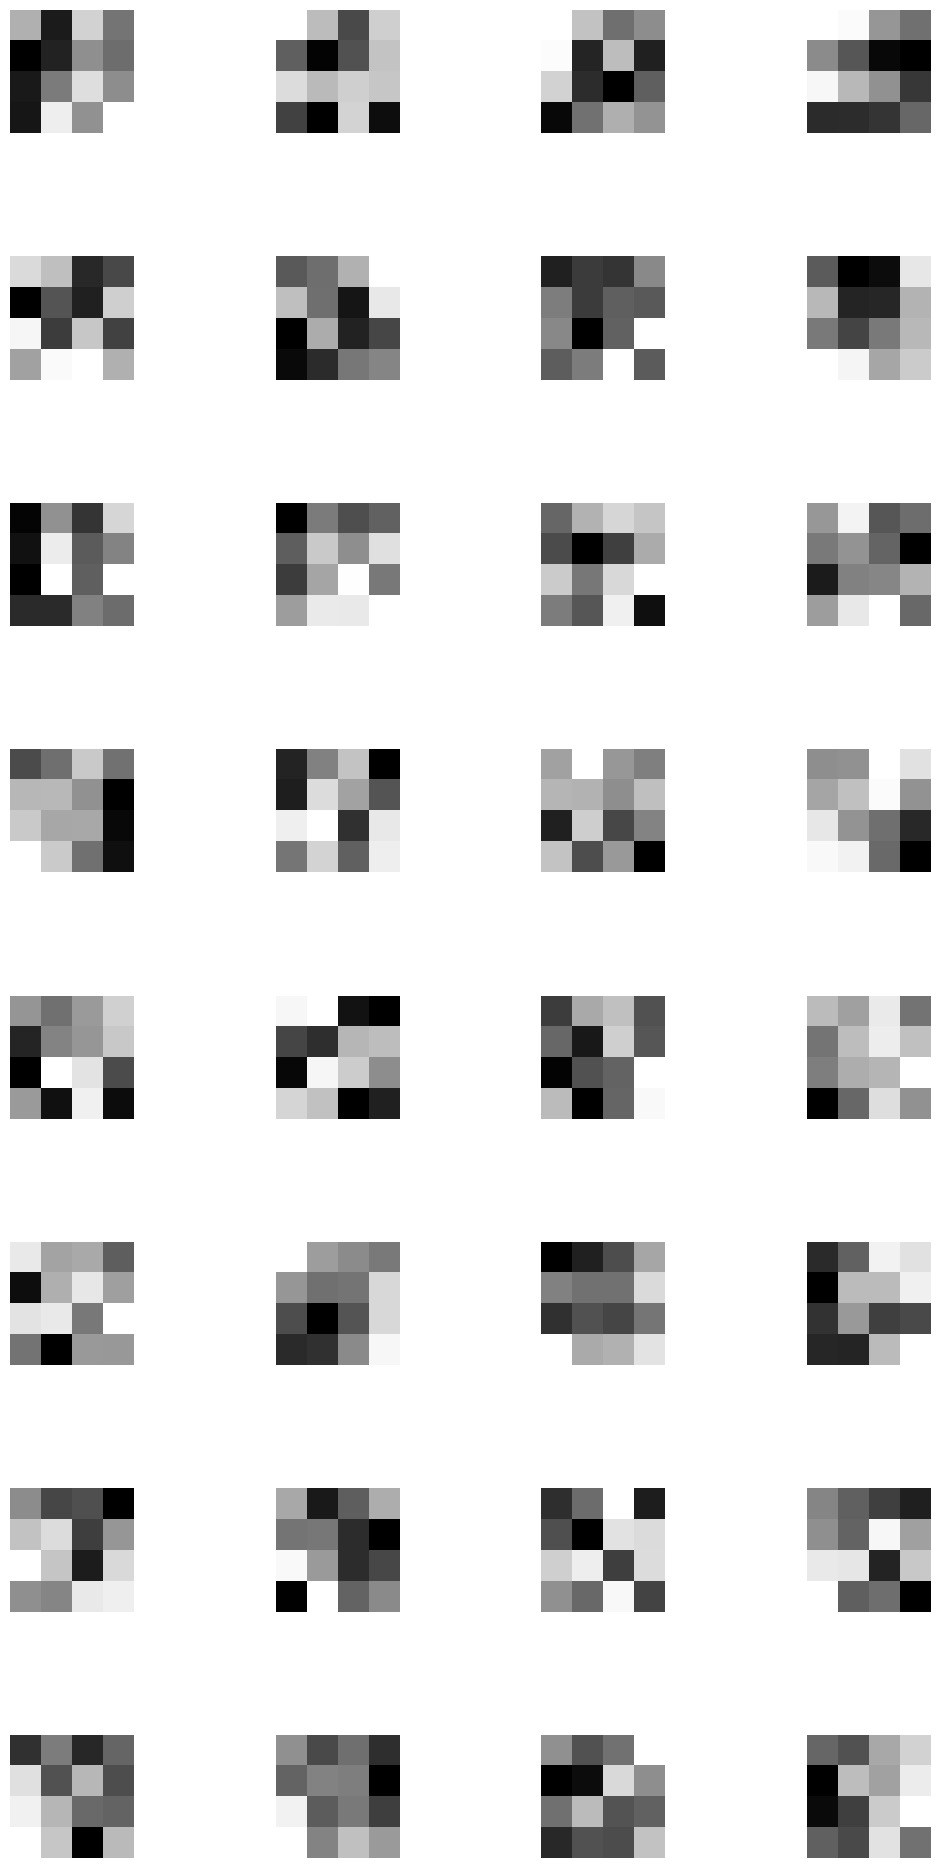

In [80]:


# Get the weights of the convolutional layers
conv_weights = model.conv_layers[0].weight

# Normalize the weights to the range [0, 1]
conv_weights_normalized = (conv_weights - conv_weights.min()) / (conv_weights.max() - conv_weights.min())

# Create a figure and subplot grid
fig, axs = plt.subplots(nrows=8, ncols=4, figsize=(12, 24))

# Iterate over the filters and plot them
for i, ax in enumerate(axs.flatten()):
    filter_img = conv_weights_normalized[i, 0].detach().cpu().numpy()
    ax.imshow(filter_img, cmap='gray')
    ax.axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=1, hspace=1)

# Show the plot
plt.show()



TypeError: Invalid shape (32, 32, 32) for image data

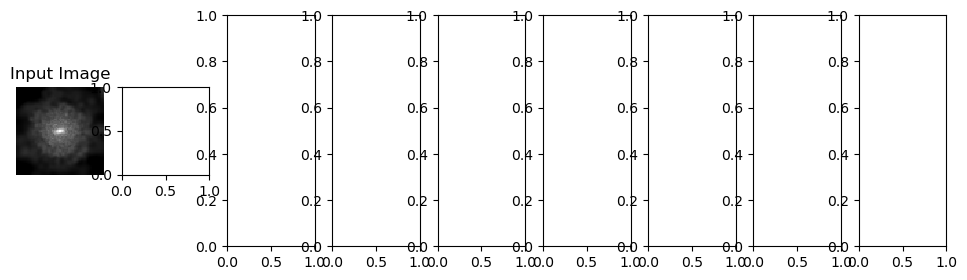

In [132]:


# Select an image from the dataset
image_index = 21
image = data[image_index]  # Assuming `data` is your dataset

# Convert the image to a PyTorch tensor and move it to the appropriate device
image_tensor = torch.from_numpy(np.expand_dims(image, axis=0)).float().to(device)

# Move the model to the appropriate device
model = model.to(device)

# Pass the image through the convolutional layers
conv_outputs = []
x = image_tensor
for layer in model.conv_layers:
    x = layer(x)
    conv_outputs.append(x)



# Create a figure and subplot grid
num_layers = len(conv_outputs)
fig, axs = plt.subplots(nrows=1, ncols=num_layers+1, figsize=(12, 3))

# Plot the input image
axs[0].imshow(image, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Input Image')

# Plot the intermediate outputs
for i in range(num_layers):
    output = conv_outputs[i]
    output_array = output.squeeze().detach().cpu().numpy()
    axs[i+1].imshow(output_array, cmap='gray')
    axs[i+1].axis('off')
    axs[i+1].set_title(f'Conv Layer {i+1} Output')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Show the plot
plt.show()



In [64]:
true = []
pred = []

with torch.no_grad():
    model.eval()
    test_loss_this_epoch = 0.0
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        target = targets.to(device)
        inputs = inputs.view(-1, 1, 64, 64)
        z = model(inputs)
        pred.append(z.cpu().numpy())
        true.append(targets.cpu().numpy())
        
true = np.concatenate(true)
pred = np.concatenate(pred)

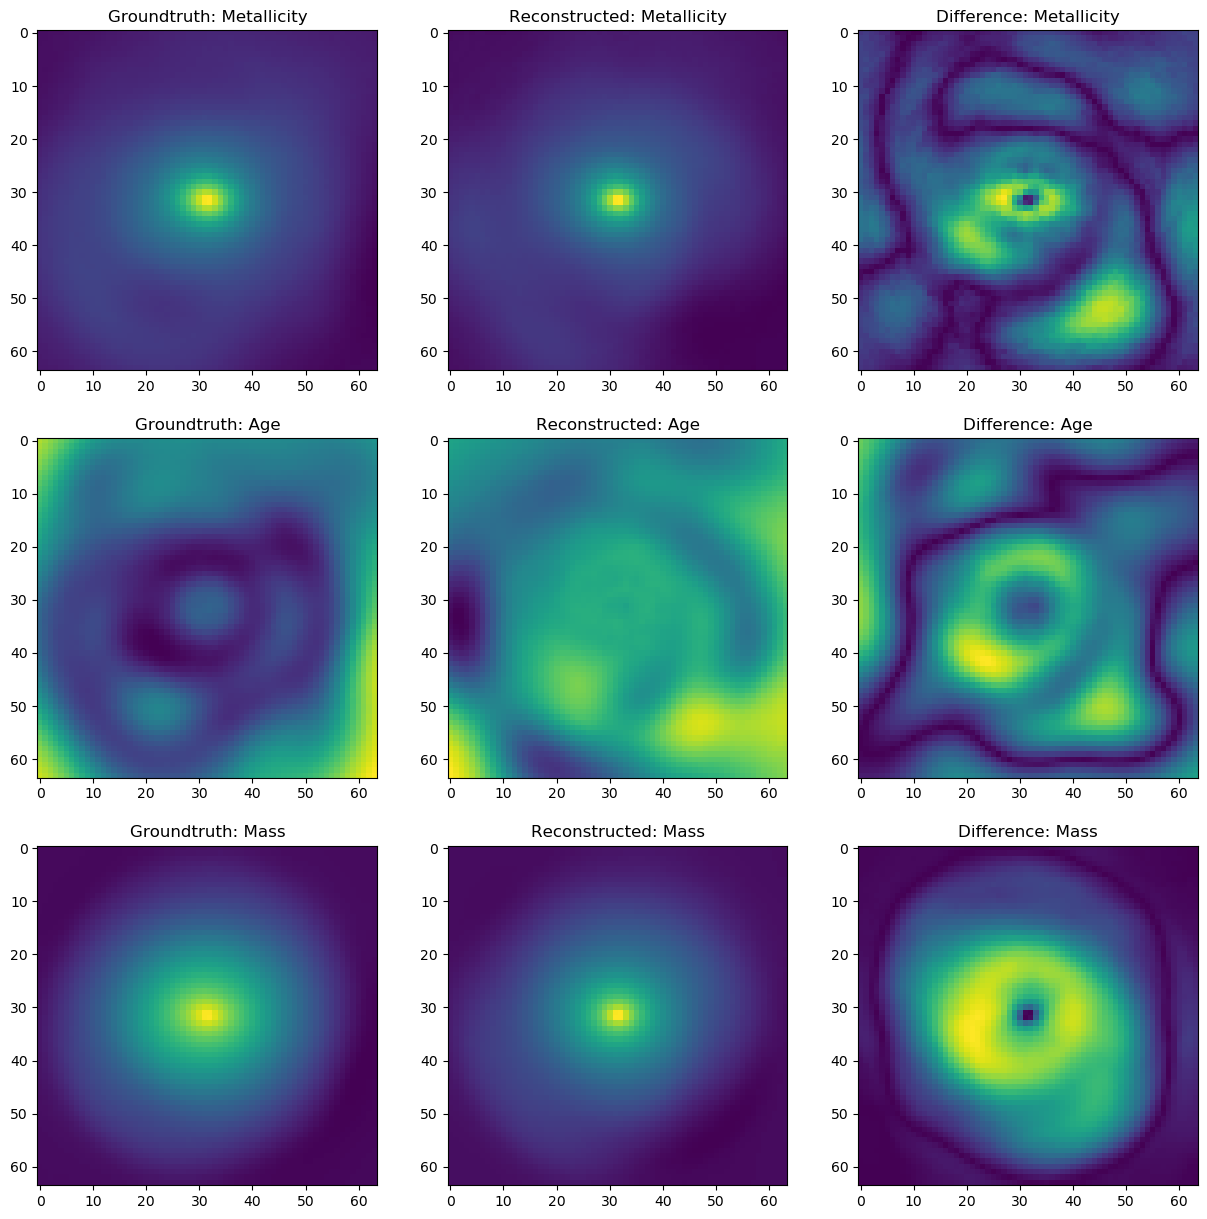

In [72]:
plot_results(6,true,pred)

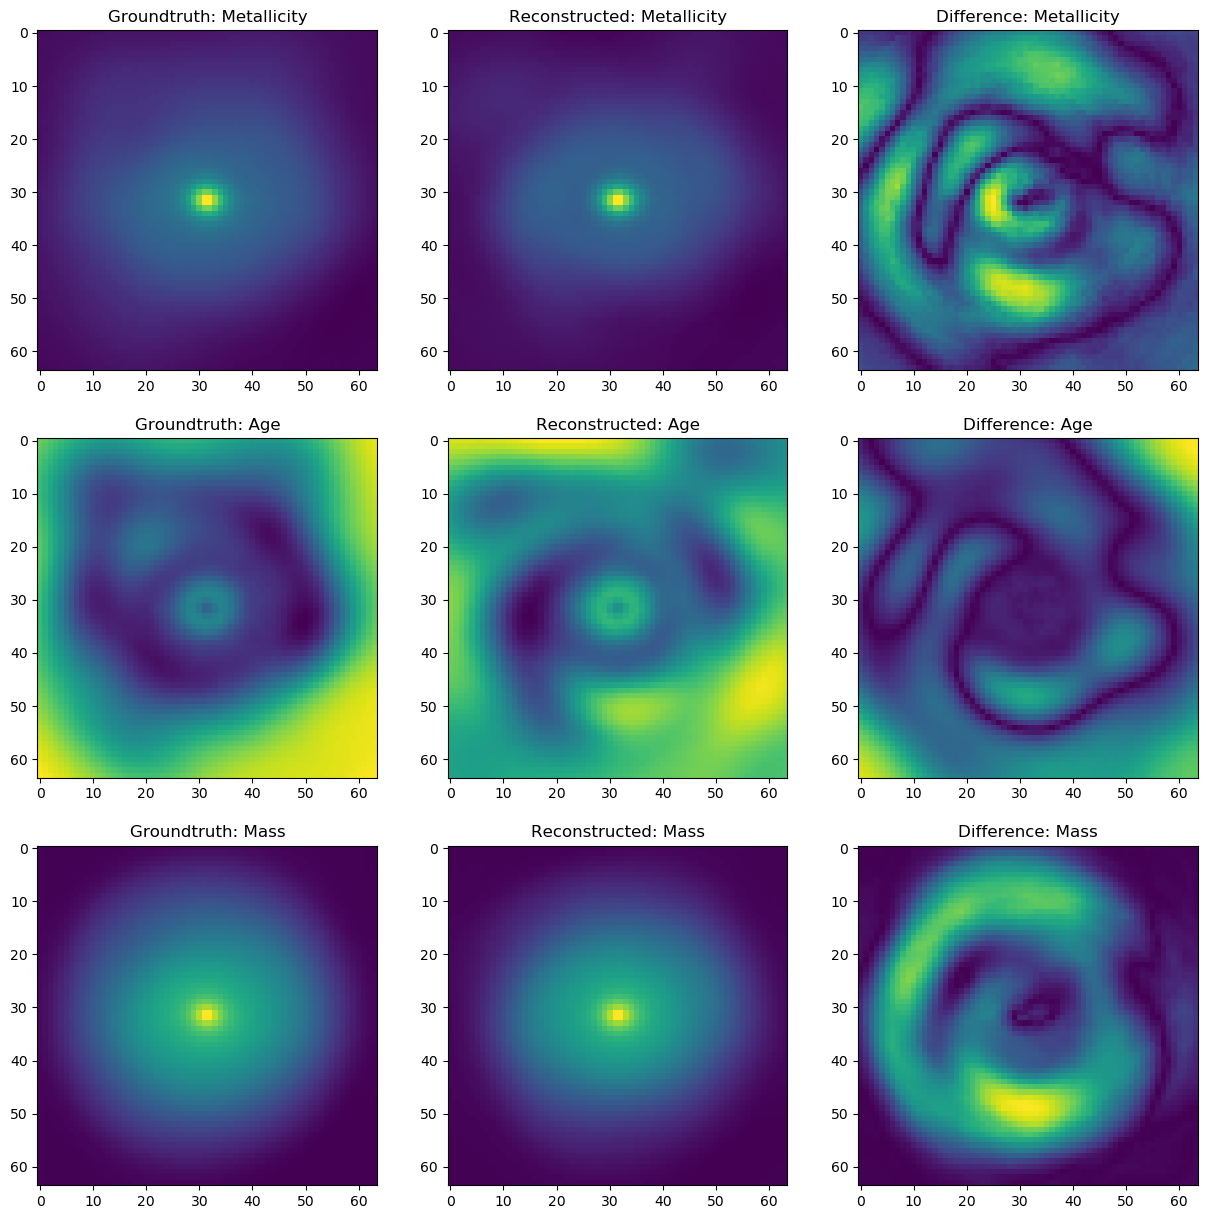

In [74]:
plot_results(17,true,pred)